# Project: Identification of dynamical systems from noisy observations
### Authors: Hee-sun Choi & Alexandre Cortiella
#### University of Colorado Boulder
#### Deparment of Aerospace Engineering Sciences


In [222]:
# System identification python code

####################### PACKAGES #######################
import numpy as np
import numpy.linalg
import numpy.matlib

from sklearn.preprocessing import PolynomialFeatures

from scipy.linalg import lstsq
from scipy.integrate import odeint

import pandas as pd

import matplotlib.pyplot as plt

## SPGL1 package
from spgl1.lsqr import lsqr
from spgl1 import spgl1, spg_lasso, spg_bp, spg_bpdn, spg_mmv
from spgl1.spgl1 import norm_l1nn_primal, norm_l1nn_dual, norm_l1nn_project
from spgl1.spgl1 import norm_l12nn_primal, norm_l12nn_dual, norm_l12nn_project


In [225]:
####################### FUNCTIONS #######################

# Simulate dynamical system

def duffing(x, t, gamma=0.1, kappa=1, epsilon=5):
    # Compute dynamics
    dsdt = [x[1], -gamma * x[1] - kappa * x[0] - epsilon * x[0] ** 3]
    return dsdt

gamma=0.1
kappa=1
epsilon=5

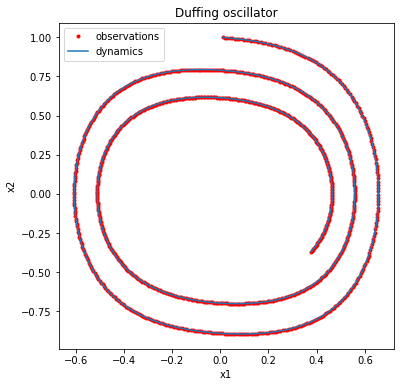

In [226]:
####################### GENERATE DATA #######################

# Simulate dynamics

t0, tf = 0, 10  # start and end
dt = 0.01  # time step
Nt = int(np.floor(tf-t0)/dt + 1) #Number of time instances
n = 2 #Number of state variables
t_span = np.linspace(t0, tf, Nt)
x0 = [0, 1]
X = odeint(duffing, x0, t_span)
x1 = X[:,0]
x2 = X[:,1]

#Corrupt states by adding noise --> Observation model y(t) = x(t) + e(t)
sigma = 0*0.01
E = sigma * np.random.randn(Nt,2)#Additive zero-mean white noise (Assumed Gaussian)

Y = X[1:,:] + E[1:,:] #(remove initial condition)
t = t_span[1:]
m = len(t)#Number of samples

y1 = Y[:,0]
y2 = Y[:,1]

#Plot dynamical system and observations
plt.figure(figsize = (6,6))
plt.plot(y1,y2,'r.')
plt.plot(x1[1:],x2[1:])
plt.title('Duffing oscillator')
plt.ylabel('x2')
plt.xlabel('x1')
plt.legend(['observations','dynamics'])
plt.show()

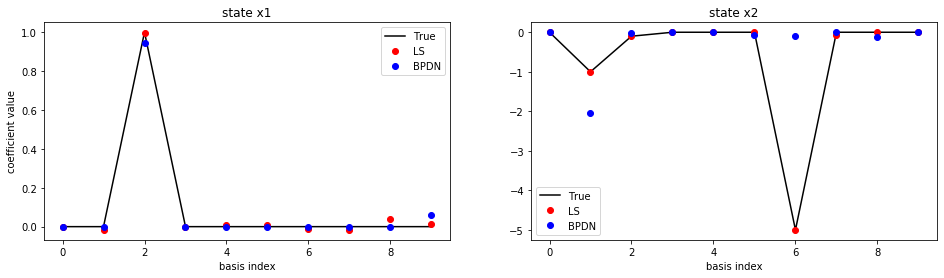

In [238]:
####################### ALGORITHM #######################

#1) Initialize noise
N = np.zeros((m,n))

#2) Subtract assumed noise from observations
X = Y - N

#3) Integrate dynamic model using quadrature

#Generate multi-variate Vandermonde matrix of degree poly_d in n variables
poly_d = 3
poly = PolynomialFeatures(poly_d)
Phi = poly.fit_transform(X)
p = Phi.shape[1]#Number of basis functions

#Generate LHS and integral matrix of the integral formulation using simple quadrature
DX = X - np.matlib.repmat(x0, m, 1)# LHS
Delta_t = t_span[1:] - t_span[0:-1]# Array with time increments for all samples in case the time grid is non-uniform
Delta_t = np.transpose(np.matlib.repmat(Delta_t,p,1))# Reshape for convenience

I = np.zeros((m,p))
for i in range(m):
   I[i,:] = np.sum(Delta_t[0:i,:] * Phi[0:i,:],axis = 0)

#True coefficients
C_true = np.zeros((p,n))
C_true[2,0] = 1
C_true[1,1] = -kappa
C_true[2,1] = -gamma
C_true[6,1] = -epsilon

#4) Solve a least squares problem
C_ls = np.zeros((p,n))

for d in range(n):
    
    b = DX[:,d]
    A = I
    
    #Solve LS
    C_ls[:,d], res, rnk, s = lstsq(A, b)
    
#4) Solve a regularized least squares problem to estimate coefficents (min |C|_1 s.t. DX - I*C <= epsilon)
C_bpdn = np.zeros((p,n))
sigma_bpdn = 0.01
for d in range(n):
    
    b = DX[:,d]
    A = I

    #Solve constrained BPDN (min |c|_1 s.t. b- A*c <= sigma)
    C_bpdn[:,d],resid,grad,info = spg_bpdn(A, b, sigma_bpdn, iter_lim=100, verbosity=0)

    
#Plot recovered coefficients
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,4))
ax1.plot(C_true[:,0],'k')
ax1.plot(C_ls[:,0],'ro')
ax1.plot(C_bpdn[:,0],'bo')
ax1.legend(('True','LS','BPDN'))
ax1.set_title('state x1')
ax1.set_xlabel('basis index')
ax1.set_ylabel('coefficient value')
ax1.set_title('state x1')

ax2.plot(C_true[:,1],'k')
ax2.plot(C_ls[:,1],'ro')
ax2.plot(C_bpdn[:,1],'bo')
ax2.legend(('True','LS','BPDN'))
ax2.set_title('state x2')
ax2.set_xlabel('basis index')

plt.show()

In [220]:
Cp_ls = pd.DataFrame(Cls)
Cp_bpdn = pd.DataFrame(Cbpdn)

,0,1
0,-0.001965,0.000205
1,-0.015331,-0.998477
2,0.996635,-0.104642
3,0.000465,-0.000041
4,0.010012,-0.001047
5,0.006583,-0.000690
6,-0.011137,-4.997982
7,-0.016819,-0.073213
8,0.039774,-0.004632
9,0.012556,-0.001327
